16:03:26 - cmdstanpy - INFO - Chain [1] start processing


Training the Prophet model...


16:03:26 - cmdstanpy - INFO - Chain [1] done processing


Prophet forecast saved to ../../Prophet/results/prophet_forecast.csv


c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


<Figure size 1000x600 with 0 Axes>

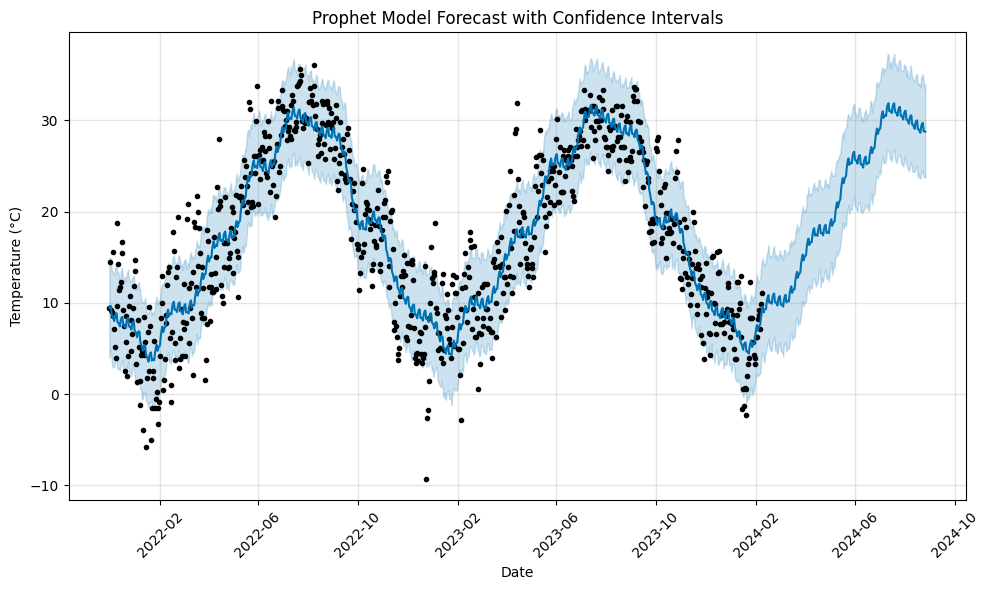

Evaluating the Prophet model on the test set...
R2 Score: 0.7985612151865085
RMSE: 3.9383834930752557
MAE: 3.137267412642316


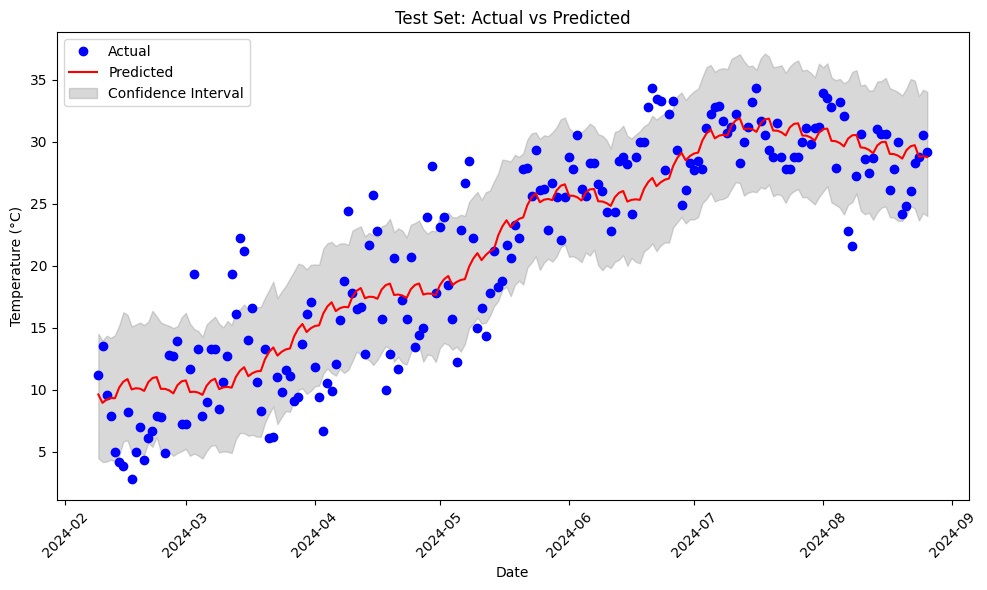

Prophet model saved to ../../Prophet/models/prophet_model.pkl
Predictions for the next 200 days saved to ../../Prophet/results/future_tempmax_predictions_200_days.csv


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_22308\1617269526.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictions_df.rename(columns={'ds': 'Date', 'yhat': 'Predicted_Max_Temp'}, inplace=True)


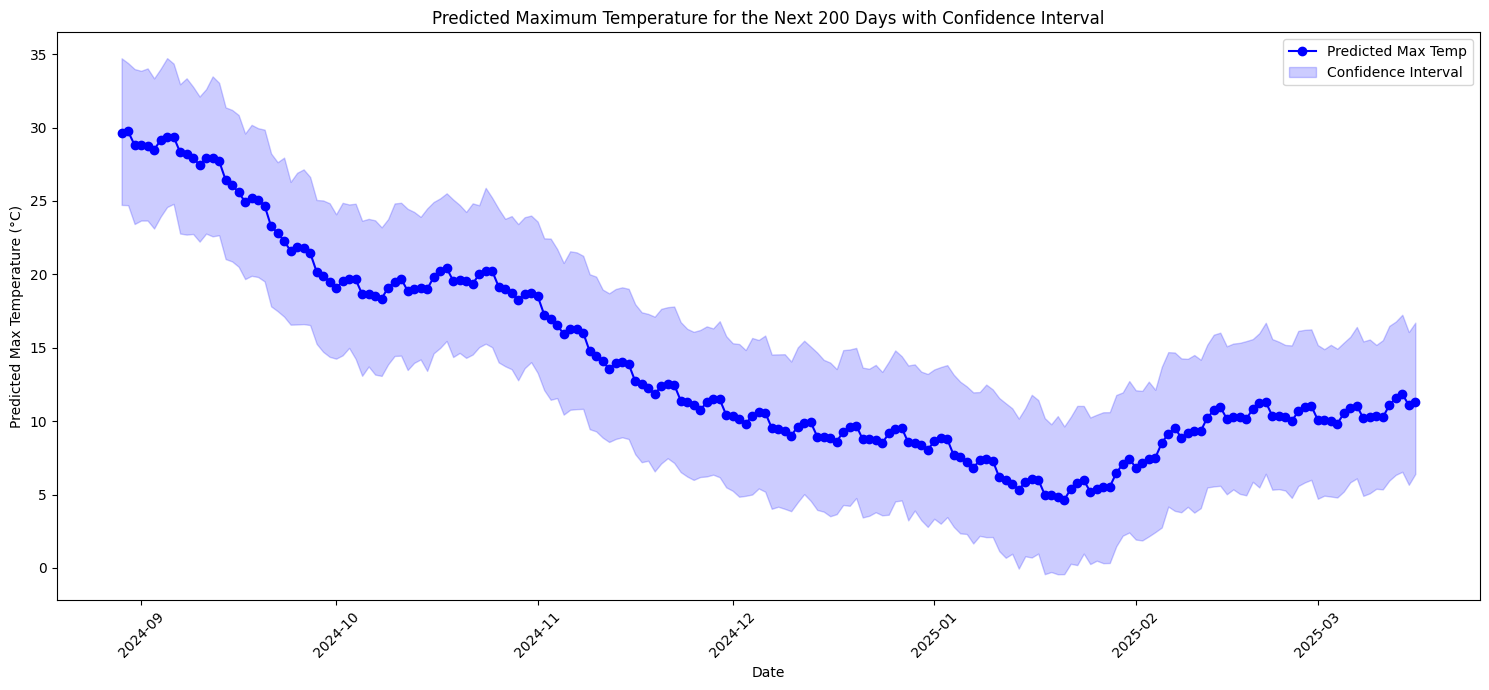

Prophet model processing complete.


In [1]:
# Filename: /models/Prophet/scripts/testProphet.ipynb

# In[0]: IMPORT AND FUNCTIONS
#region 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import os
import pickle
#endregion

# Ensure the necessary directories exist
base_dir = "../../Prophet"
os.makedirs(f"{base_dir}/preprocessing", exist_ok=True)
os.makedirs(f"{base_dir}/results", exist_ok=True)
os.makedirs(f"{base_dir}/figures", exist_ok=True)
os.makedirs(f"{base_dir}/models", exist_ok=True)

# In[1]: STEP 2. GET THE DATA
file_path = "../../../data/NewYork.csv"
data = pd.read_csv(file_path)

# In[2]: HANDLE DATETIME
data['datetime'] = pd.to_datetime(data['datetime'])
data['day_of_year'] = data['datetime'].apply(lambda x: x.timetuple().tm_yday)
data['month'] = data['datetime'].dt.month
data['hour'] = data['datetime'].dt.hour
data['year'] = data['datetime'].dt.year

# In[3]: DROP UNNECESSARY COLUMNS
columns_to_drop = ['name', 'stations', 'icon', 'description', 'sunrise', 'sunset', 'preciptype', 'snow', 'conditions']
data = data.drop(columns=columns_to_drop)

# In[4]: HANDLE MISSING VALUES
numeric_cols = data.select_dtypes(include=[np.number]).columns
data[numeric_cols] = data[numeric_cols].fillna(data[numeric_cols].mean())

# In[5]: FEATURE ENGINEERING
data['tempmax_lag1'] = data['tempmax'].shift(1)
data['tempmax_lag3'] = data['tempmax'].shift(3)
data['humidity_lag1'] = data['humidity'].shift(1)
data['tempmax_rolling_mean_3'] = data['tempmax'].rolling(window=3).mean()
data['tempmax_rolling_std_3'] = data['tempmax'].rolling(window=3).std()
data['precip_rolling_sum_7'] = data['precip'].rolling(window=7).sum()

# Ensure features are aligned with temperature trends
data['day_of_year_cos'] = np.cos(2 * np.pi * data['day_of_year'] / 365)
data['day_of_year_sin'] = np.sin(2 * np.pi * data['day_of_year'] / 365)

# Fill NaNs only in numeric columns
numeric_cols = data.select_dtypes(include=[np.number]).columns
data[numeric_cols] = data[numeric_cols].fillna(data[numeric_cols].mean())

# Interaction feature
data['temp_precip_interaction'] = data['temp'] * data['precip']

# In[6]: VISUALIZE RAW DATA
# Histograms for each numeric column
data.hist(bins=50, figsize=(20, 15))
plt.savefig(f"{base_dir}/figures/hist_raw_data.png")
plt.close()

# Scatter plot for a selected feature
plt.figure(figsize=(10, 6))
plt.scatter(data['humidity'], data['tempmax'], alpha=0.2)
plt.xlabel('Humidity')
plt.ylabel('Maximum Temperature')
plt.title('Scatter Plot: Humidity vs Maximum Temperature')
plt.savefig(f"{base_dir}/figures/scatter_1_feat.png")
plt.close()

# Scatter matrix for all selected features
import seaborn as sns
sns.pairplot(data[[
    'tempmax', 'tempmin', 'temp', 'humidity', 
    'windspeed', 'precip', 'day_of_year_cos', 'day_of_year_sin'
]])
plt.savefig(f"{base_dir}/figures/scatter_mat_all_feat.png")
plt.close()

# In[7]: PREPARE DATA FOR PROPHET
# Prophet requires 'ds' for the date column and 'y' for the target
data.rename(columns={'datetime': 'ds', 'tempmax': 'y'}, inplace=True)

# In[8]: SPLIT DATA INTO TRAIN AND TEST SETS
split_date = data['ds'].quantile(0.8)
train_data = data[data['ds'] <= split_date]
test_data = data[data['ds'] > split_date]

# In[9]: TRAIN THE PROPHET MODEL
print("Training the Prophet model...")
prophet_model = Prophet(
    changepoint_prior_scale=0.1, 
    seasonality_prior_scale=10.0, 
    yearly_seasonality=True, 
    weekly_seasonality=True, 
    daily_seasonality=False
)
prophet_model.fit(train_data)

# In[10]: MAKE FUTURE PREDICTIONS
# Generate future dates
future_days = 200
future_dates = prophet_model.make_future_dataframe(periods=future_days)

# Make predictions
forecast = prophet_model.predict(future_dates)

# Save the forecast
forecast_path = f"{base_dir}/results/prophet_forecast.csv"
forecast.to_csv(forecast_path, index=False)
print(f"Prophet forecast saved to {forecast_path}")

# In[11]: VISUALIZE THE FORECAST
plt.figure(figsize=(10, 6))
prophet_model.plot(forecast)
plt.title('Prophet Model Forecast with Confidence Intervals')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f"{base_dir}/figures/prophet_forecast_plot.png")
plt.show()

# In[12]: EVALUATE THE MODEL
print("Evaluating the Prophet model on the test set...")
# Predict on the test set
test_forecast = prophet_model.predict(test_data[['ds']])

# Evaluate
y_true = test_data['y']
y_pred = test_forecast['yhat']

r2 = r2_score(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)

# Save evaluation metrics
with open(f"{base_dir}/results/model_evaluation.txt", "w") as file:
    file.write(f"R2 Score: {r2}\n")
    file.write(f"RMSE: {rmse}\n")
    file.write(f"MAE: {mae}\n")

print(f"R2 Score: {r2}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

# In[13]: VISUALIZE TEST RESULTS
plt.figure(figsize=(10, 6))
plt.plot(test_data['ds'], y_true, 'bo', label='Actual')
plt.plot(test_data['ds'], y_pred, 'r-', label='Predicted')
plt.fill_between(test_data['ds'], test_forecast['yhat_lower'], test_forecast['yhat_upper'], color='gray', alpha=0.3, label='Confidence Interval')
plt.title('Test Set: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.savefig(f"{base_dir}/figures/test_set_results.png")
plt.show()

# In[14]: SAVE THE MODEL
# Save the trained Prophet model
model_path = f"{base_dir}/models/prophet_model.pkl"
with open(model_path, 'wb') as file:
    pickle.dump(prophet_model, file)
print(f"Prophet model saved to {model_path}")

# In[15]: FUTURE PREDICTIONS
# Reload the original data for creating future predictions
original_data = pd.read_csv(file_path)
original_data['datetime'] = pd.to_datetime(original_data['datetime'])
original_data['day_of_year'] = original_data['datetime'].dt.dayofyear

# Generate future dates
future_days = 200
start_date = pd.to_datetime('today').normalize()
future_dates = pd.date_range(start=start_date, periods=future_days, freq='D')

# Create base DataFrame for future predictions
future_data = pd.DataFrame({'ds': future_dates})

# Engineer additional features similar to training data
future_data['day_of_year'] = future_data['ds'].dt.dayofyear
future_data['day_of_year_cos'] = np.cos(2 * np.pi * future_data['day_of_year'] / 365)
future_data['day_of_year_sin'] = np.sin(2 * np.pi * future_data['day_of_year'] / 365)

# Make predictions
future_tempmax_predictions = prophet_model.predict(future_data)

# Compile predictions
predictions_df = future_tempmax_predictions[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
predictions_df.rename(columns={'ds': 'Date', 'yhat': 'Predicted_Max_Temp'}, inplace=True)

# Save predictions
predictions_df.to_csv(f"{base_dir}/results/future_tempmax_predictions_200_days.csv", index=False)
print("Predictions for the next 200 days saved to ../../Prophet/results/future_tempmax_predictions_200_days.csv")

# Visualization: Plot predictions and actual data
plt.figure(figsize=(15, 7))
plt.plot(predictions_df['Date'], predictions_df['Predicted_Max_Temp'], label='Predicted Max Temp', color='blue', marker='o')
plt.fill_between(predictions_df['Date'], predictions_df['yhat_lower'], predictions_df['yhat_upper'], color='blue', alpha=0.2, label='Confidence Interval')
plt.title('Predicted Maximum Temperature for the Next 200 Days with Confidence Interval')
plt.xlabel('Date')
plt.ylabel('Predicted Max Temperature (°C)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.savefig(f"{base_dir}/figures/future_tempmax_predictions_with_confidence_interval.png")
plt.show()

print("Prophet model processing complete.")
